In [140]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
import statistics

#test_sample has 600+ data points. control conversion rate = 20%, treatment conversion rate = 30%
#test_sample_2 has 50 data points. control conversion rate = 20%, treatment conversion rate = 30%

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [141]:
df = pd.read_csv('C:/Users/jlwong/Desktop/Jupyter/test_sample.csv')

df.head()

,customer_id,date,group,channel,converted
0,1234,1/1/2022,control,twitter,0
1,1235,1/3/2022,treatment,twitter,0
2,1236,1/3/2022,treatment,twitter,1
3,1237,1/2/2022,treatment,instagram,1
4,1238,1/4/2022,control,twitter,0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  679 non-null    int64 
 1   date         679 non-null    object
 2   group        679 non-null    object
 3   channel      679 non-null    object
 4   converted    679 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 26.6+ KB


In [143]:
pd.crosstab(df['group'],df['channel'])

channel,instagram,twitter
group,,
control,160,168
treatment,183,168


In [144]:
session_counts = df['customer_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [145]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['customer_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 679 entries


In [146]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates_tab = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates_tab.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates_tab

,conversion_rate,std_deviation,std_error
group,,,
control,0.207317,0.405385,0.022384
treatment,0.299145,0.457884,0.024440


In [147]:
conv_con = df[(df.group=='control') & (df.converted==1)]['customer_id'].nunique() 
tot_con = df[(df.group=='control')]['customer_id'].nunique()
conv_rate_con = conv_con/tot_con
print("{:.2f}".format(conv_rate_con))

0.21


In [148]:
conv_treat = df[(df.group=='treatment') & (df.converted==1)]['customer_id'].nunique() 
tot_treat = df[(df.group=='treatment')]['customer_id'].nunique()
conv_rate_treat = conv_treat/tot_treat
print('{:.2f}'.format(conv_rate_treat))

0.30


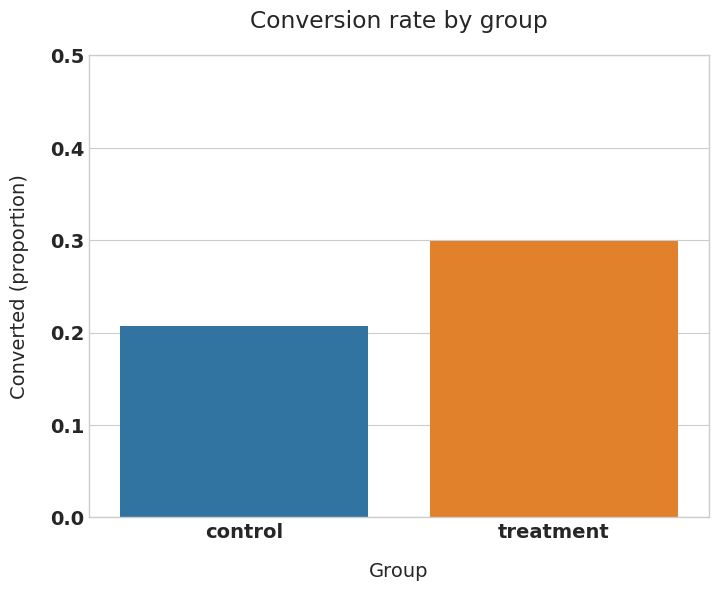

In [149]:
plt.figure(figsize=(8,6))

sns.barplot(x=df['group'], y=df['converted'], ci=False)

plt.ylim(0, 0.5)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [150]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.74
p-value: 0.006
ci 95% for control group: [0.163, 0.251]
ci 95% for treatment group: [0.251, 0.347]


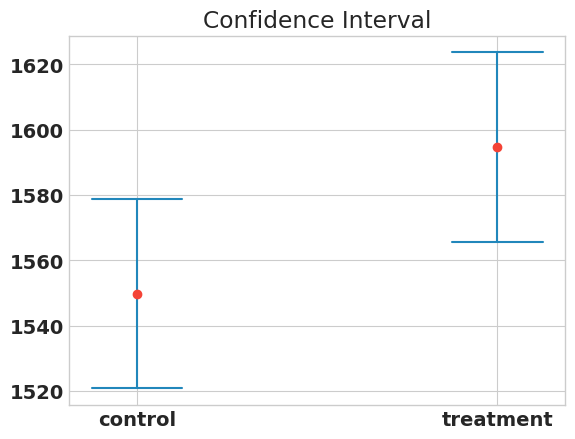

In [151]:
def plot_confidence_interval(x, values, z=z_stat, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / math.sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1, 2], ['control', 'treatment'])
plt.title('Confidence Interval')
plot_confidence_interval(1, df[(df.group=='control')]['customer_id'])
plot_confidence_interval(2, df[(df.group=='treatment')]['customer_id'])
plt.show()

In [153]:
from scipy.stats import norm

lift = conv_rate_treat - conv_rate_con
var_con = (conv_rate_con * (1 - conv_rate_con)) / df[(df.group=='control')]['customer_id'].nunique() 
var_treat = (conv_rate_treat * (1 - conv_rate_treat)) / df[(df.group=='treatment')]['customer_id'].nunique() 
var = var_con + var_treat

# Generate a range of values across the distribution from +/- 3 sd around the mean 
# 100 values
# conv_rate_con = mean
# **0.5 = to the 0.5 power
con_line = np.linspace(-3 * var_con**0.5 + conv_rate_con, 3 * var_con**0.5 + conv_rate_con, 100) 
test_line = np.linspace(-3 * var_treat**0.5 +  conv_rate_treat, 3 * var_treat**0.5 + conv_rate_treat, 100)


In [139]:
con_line

array([0.14016621, 0.14152279, 0.14287937, 0.14423596, 0.14559254,
       0.14694912, 0.14830571, 0.14966229, 0.15101887, 0.15237546,
       0.15373204, 0.15508862, 0.1564452 , 0.15780179, 0.15915837,
       0.16051495, 0.16187154, 0.16322812, 0.1645847 , 0.16594129,
       0.16729787, 0.16865445, 0.17001104, 0.17136762, 0.1727242 ,
       0.17408079, 0.17543737, 0.17679395, 0.17815054, 0.17950712,
       0.1808637 , 0.18222028, 0.18357687, 0.18493345, 0.18629003,
       0.18764662, 0.1890032 , 0.19035978, 0.19171637, 0.19307295,
       0.19442953, 0.19578612, 0.1971427 , 0.19849928, 0.19985587,
       0.20121245, 0.20256903, 0.20392562, 0.2052822 , 0.20663878,
       0.20799536, 0.20935195, 0.21070853, 0.21206511, 0.2134217 ,
       0.21477828, 0.21613486, 0.21749145, 0.21884803, 0.22020461,
       0.2215612 , 0.22291778, 0.22427436, 0.22563095, 0.22698753,
       0.22834411, 0.2297007 , 0.23105728, 0.23241386, 0.23377044,
       0.23512703, 0.23648361, 0.23784019, 0.23919678, 0.24055

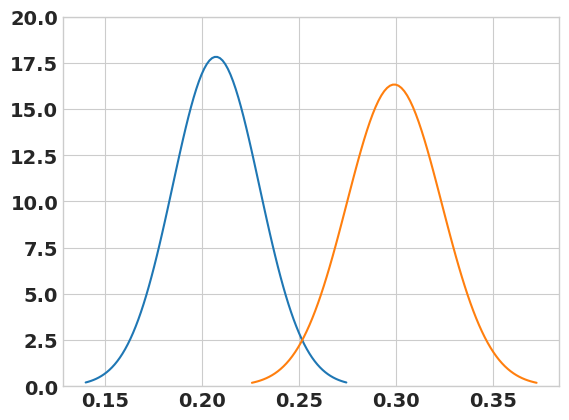

In [165]:
# Plot the probabilities across the  distribution of conversion rates 
# pdf = probability density function pdf(x, loc=0, scale=1)
plt.plot(con_line,norm.pdf( con_line, conv_rate_con,var_con**0.5) ) 
plt.plot(test_line,norm.pdf( test_line, conv_rate_treat, var_treat**0.5) ) 
plt.ylim(0,20)
plt.show()

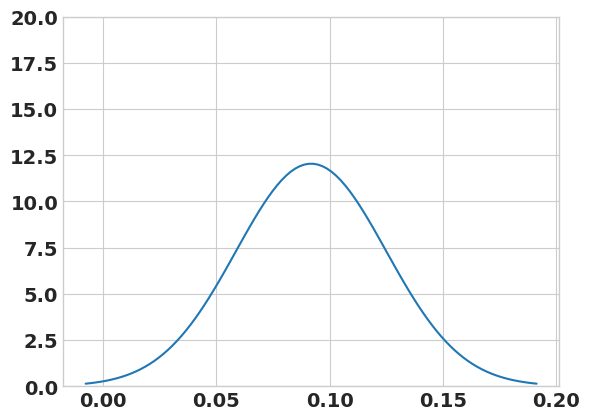

In [174]:
# Plot our difference in conversion rates  # as a distribution 
diff_line = np.linspace(-3 * var**0.5 + lift, 3 * var**0.5 + lift, 100 ) 
plt.plot(diff_line,norm.pdf( diff_line, lift, var**0.5) ) 
plt.ylim(0,20)
plt.show() 

In [223]:
# Define labels, positions, bar heights and error bar heights
std_treat = np.std(test_line)
std_con = np.std(con_line)

labels = ['control', 'treatment']
x_pos = np.arange(len(labels))
CTEs = [conv_rate_con, conv_rate_treat]
# error = [std_con,std_treat]
error = [std_con,std_treat]

In [214]:
std_treat

0.0427568050219919

In [218]:
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

ci 95% for control group: [0.163, 0.251]
ci 95% for treatment group: [0.251, 0.347]


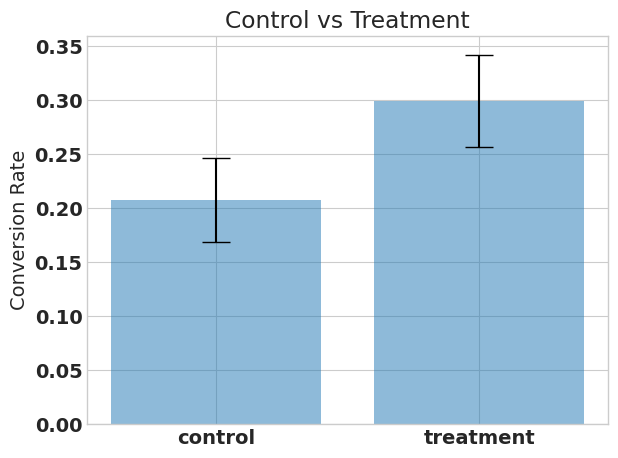

In [230]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Conversion Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Control vs Treatment')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [166]:
df_2 = pd.read_csv('C:/Users/jlwong/Desktop/Jupyter/test_sample_2.csv')

df_2.head()

,customer_id,date,group,channel,converted
0,1234,1/4/2022,control,twitter,0
1,1235,1/1/2022,treatment,twitter,1
2,1236,1/3/2022,control,twitter,0
3,1237,1/4/2022,treatment,twitter,1
4,1238,1/4/2022,treatment,twitter,0


In [167]:
conversion_rates_2 = df_2.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates_tab_2 = conversion_rates_2.agg([np.mean, std_p, se_p])
conversion_rates_tab_2.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates_tab_2

,conversion_rate,std_deviation,std_error
group,,,
control,0.166667,0.372678,0.087841
treatment,0.354839,0.478464,0.085935


In [168]:
conv_con_2 = df_2[(df_2.group=='control') & (df_2.converted==1)]['customer_id'].nunique() 
tot_con_2 = df_2[(df_2.group=='control')]['customer_id'].nunique()
conv_rate_con_2 = conv_con_2/tot_con_2
print("{:.2f}".format(conv_rate_con_2))

0.17


In [169]:
conv_treat_2 = df_2[(df_2.group=='treatment') & (df_2.converted==1)]['customer_id'].nunique() 
tot_treat_2 = df_2[(df_2.group=='treatment')]['customer_id'].nunique()
conv_rate_treat_2 = conv_treat_2/tot_treat_2
print('{:.2f}'.format(conv_rate_treat_2))

0.35


In [170]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results_2 = df_2[df_2['group'] == 'control']['converted']
treatment_results_2 = df_2[df_2['group'] == 'treatment']['converted']
n_con_2 = control_results_2.count()
n_treat_2 = treatment_results_2.count()
successes_2 = [control_results_2.sum(), treatment_results_2.sum()]
nobs_2 = [n_con_2, n_treat_2]

z_stat_2, pval_2 = proportions_ztest(successes_2, nobs=nobs_2)
(lower_con_2, lower_treat_2), (upper_con_2, upper_treat_2) = proportion_confint(successes_2, nobs=nobs_2, alpha=0.05)

print(f'z statistic: {z_stat_2:.2f}')
print(f'p-value: {pval_2:.3f}')
print(f'ci 95% for control group: [{lower_con_2:.3f}, {upper_con_2:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat_2:.3f}, {upper_treat_2:.3f}]')

z statistic: -1.41
p-value: 0.160
ci 95% for control group: [0.000, 0.339]
ci 95% for treatment group: [0.186, 0.523]


In [171]:
from scipy.stats import norm

lift_2 = conv_rate_treat_2 - conv_rate_con_2
var_con_2 = (conv_rate_con_2 * (1 - conv_rate_con_2)) / df_2[(df_2.group=='control')]['customer_id'].nunique() 
var_treat_2 = (conv_rate_treat_2 * (1 - conv_rate_treat_2)) / df_2[(df_2.group=='treatment')]['customer_id'].nunique() 
var_2 = var_con_2 + var_treat_2

# Generate a range of values across the distribution from +/- 3 sd around the mean 
# 100 values
# conv_rate_con = mean
# **0.5 = to the 0.5 power
con_line_2 = np.linspace(-3 * var_con_2**0.5 + conv_rate_con_2, 3 * var_con_2**0.5 + conv_rate_con_2, 100) 
test_line_2 = np.linspace(-3 * var_treat_2**0.5 +  conv_rate_treat_2, 3 * var_treat_2**0.5 + conv_rate_treat_2, 100)


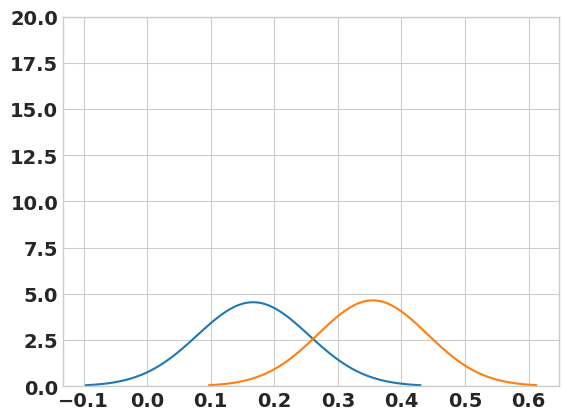

In [172]:
# Plot the probabilities across the  distribution of conversion rates 
# pdf = probability density function pdf(x, loc=0, scale=1)
plt.plot(con_line_2,norm.pdf( con_line_2, conv_rate_con_2,var_con_2**0.5) ) 
plt.plot(test_line_2,norm.pdf( test_line_2, conv_rate_treat_2, var_treat_2**0.5) ) 
plt.ylim(0,20)
plt.show()

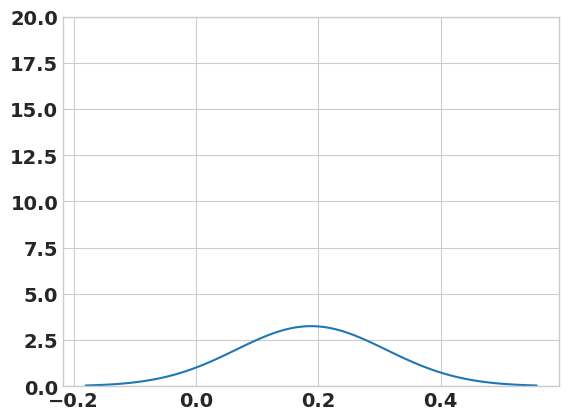

In [175]:
# Plot our difference in conversion rates  # as a distribution 
diff_line_2 = np.linspace(-3 * var_2**0.5 + lift_2, 3 * var_2**0.5 + lift_2, 100 ) 
plt.plot(diff_line_2,norm.pdf( diff_line_2, lift_2, var_2**0.5) ) 
plt.ylim(0,20)
plt.show() 